In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from warnings import filterwarnings
sns.set_theme()
%config InlineBackend.figure_format = 'retina'

import scipy.stats as stats
import pylab
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler,LabelEncoder
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LogisticRegression 
from sklearn.metrics import accuracy_score,roc_auc_score,precision_score,recall_score,classification_report,precision_recall_curve,confusion_matrix,roc_curve
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBRFClassifier
from sklearn.neural_network import MLPClassifier
filterwarnings('ignore')

In [ ]:
train='../input/health-insurance-cross-sell-prediction/train.csv'
df=pd.read_csv(train)
df

**DATA EXPLORATION**

In [ ]:
df.info()

In [ ]:
df.isnull().sum()

We can see that there is no missing values in our dataset .Thus we do not need to impute any values and can proceed for further analysis

In [ ]:
df.shape

In [ ]:
df.dtypes

In [ ]:
df.describe(include='all')

In [ ]:
print(df['Age'].mean())
print(df['Vehicle_Age'].unique())

In [ ]:
df.duplicated().value_counts().to_frame('values')

In [ ]:
df.drop(['id'],axis=1,inplace=True)
df.drop(['Region_Code'],axis=1,inplace=True)
df.drop(['Policy_Sales_Channel'],axis=1,inplace=True)

So we can see there is no duplicate elements present in our dataset


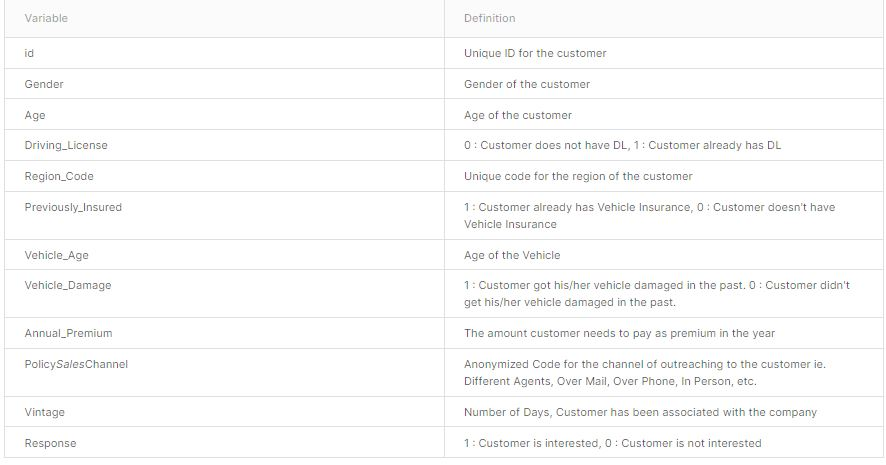

**BUISNESS MODEL -**
Predict, whether the customer would be interested in Vehicle insurance, we have information about demographics (gender, age, region code type), Vehicles (Vehicle Age, Damage), Policy (Premium, sourcing channel) etc.

In [ ]:
df.columns

In [ ]:
feature=[ 'Gender', 'Age', 'Driving_License', 'Region_Code',
       'Previously_Insured', 'Vehicle_Age', 'Vehicle_Damage', 'Annual_Premium',
       'Policy_Sales_Channel', 'Vintage', 'Response']

In [ ]:
 list(enumerate(feature))

In [ ]:
df.skew(axis=0).to_frame('Skewed Values')

**UNIVARIATE ANALYSIS**

In [ ]:
sns.countplot(df['Response'],palette="viridis")

In [ ]:
print('Negative Responses %',(df['Response'].value_counts()[0]/len(df))*100)
print('Positive Responses %',(df['Response'].value_counts()[1]/len(df))*100)

From the above graph and percentages we can clearly see that negative response is more than positive response in terms of buying insurance 


In [ ]:
sns.countplot(df['Driving_License'],palette="viridis")

In [ ]:
sns.catplot(x='Response',y='Gender',data=df,kind='bar',palette="viridis")
plt.title('Gender vs Response',fontsize=15)

From this graph we can clearly see that Male are having positive response towards insurance purchase while female are having negative response.Thus from this we can conclude that the most targeted customers are Male than Female.So, we need to focus on strengthening the Female customers buyers for buying the insurance.

In [ ]:
plt.figure(figsize=(15,10))
plt.title('Different Age Analysis')
sns.countplot(df['Age'],palette='viridis')

In [ ]:
sns.countplot(df['Vehicle_Age'],hue=df['Response'],palette='viridis')
plt.title('Vehicle Age with Response Comparison',fontsize=15)
plt.ylabel('Resonse')

We can see that buyers whose vehicle are between 1 to 2 years are more entrusted to buy insurance rather whose vehicle are less than 1 year or more than 2 years.

In [ ]:
fig=plt.figure(figsize=(20,10))
sns.distplot(df[df['Response']==0]['Age'],color='indigo',hist_kws={'alpha':0.6})
sns.distplot(df[df['Response']==1]['Age'],color='orange',hist_kws={'alpha':0.5})
fig.legend(labels=['Not Buying','Buying'],fontsize=15)
plt.xlabel('Age',fontsize=20)
plt.ylabel('Response',fontsize=20)
plt.title('Age Vs People Buying And Not Buying Insurance',fontsize=20)

In [ ]:
fig=plt.figure(figsize=(20,10))
sns.distplot(df[df['Response']==0]['Annual_Premium'],color='coral',hist_kws={'alpha':0.9})
fig.legend(labels=['Not Buying'],fontsize=15)
plt.xlabel('Annual Premium',fontsize=20)
plt.ylabel('Response',fontsize=20)
plt.title('Annual Premium Vs Not Buying Insurance ',fontsize=20)

In [ ]:
fig=plt.figure(figsize=(20,10))
sns.distplot(df[df['Response']==1]['Annual_Premium'],color='darkviolet',hist_kws={'alpha':0.4})
fig.legend(labels=['Buying'],fontsize=15)
plt.xlabel('Annual Premium',fontsize=20)
plt.ylabel('Response',fontsize=20)
plt.title('Annual Premium Vs People Buying ',fontsize=20)

In [ ]:
plt.figure(figsize=(8,6))
sns.countplot(df['Previously_Insured'],hue=df['Response'],palette='viridis')
plt.title('Comparison between Previous Insured and Response')
plt.ylabel('Response')

In [ ]:
df.columns

In [ ]:
plt.figure(figsize=(15,7))
sns.countplot(df['Age'],hue=df['Response'],palette='viridis')
plt.title('Response Against Each Age')
plt.ylabel('Response')

From this we can understand the different Ages of People are buing the      insurance :-

*   Thus, it clearly shows that the trend of positive resoponse for buying the insurance increases between 21 to 25 and then again it get decreases from the Age 26 there is a little dip that shows that people in that age group are not interested in buying the insurance.
*   From Age 30 till 46 it shows people trust for need of buying insurance increases and this shows that people from this age group are becoming more cautious for their future.
*  From Age 47 we can see that the trend is decreasing, it may happen that people already bought long-term insurance thus the people are not investing in more insurances or because people dont want to invest in their Old Age. 





**MULTIVARIATE ANALYSIS**

In [ ]:
bin=np.linspace(min(df['Age']),max(df['Age']),5)
groups=['Young_Age','Medium_Age','Old_Age','Senior_Citizen']
df['Age-binned']=pd.cut(df['Age'],bins=bin,labels=groups)

In [ ]:
plt.figure(figsize=(10,8))
sns.countplot(df['Age-binned'],hue=df['Response'],palette='viridis')
plt.title('Response Vs Age Group')
plt.ylabel('Response')

From the above graph again we can categorise which Age group people are having more positive positive response and negative response


*   From this we can understand that people in Middle Age group are having more positive response and less negative response but the Young Age group are have more negative response than positive response and also the negative response among this group is more than any Age category group thus we need to increase the alertness or better the product offering for this category of Age group so that we get more positive response from this Age group and also from other Age group.




In [ ]:
sns.catplot(x='Gender',y='Age',hue='Previously_Insured',col='Response',data=df,kind='bar',palette='rocket')

In this we can understand that the negative response among Male are little over the Age 40 for those who are not previously insured and also Age between 30 to 40 also have higher negative response and that same with female also who are not previously insured upto Age 40 and upto Age 30 for those previously insured

We can see that positive response for Male are above 40 for those who were not previously insured against those who were previously insured and same for Female also that Age little over 40 have more positive response for not previously insured against those who were already previously insured

In [ ]:
sns.catplot(x='Gender',y='Age',hue='Vehicle_Damage',col='Response',data=df,kind='bar',palette='rocket')

In [ ]:
plt.figure(figsize=(15,10))
sns.heatmap(df.corr(),annot=True,linecolor='white',cmap='magma',linewidths=2)

In [ ]:
sns.scatterplot(x='Gender',y='Annual_Premium',data=df)

In [ ]:
sns.pairplot(df,hue='Response',palette='viridis')

**From the overall analysis :-**


*   **We can understand that some of the product offering of the insurance company is good proposition for the buyers and thus getting positive response among few categories.** 

* **Overall there many negative response than positive response from the customers thus we can assume that most of the product offering from the insurance company are degraded or the customer after sales response is not good or the product offering are not covering today's world customer needs or there is lack of marketing strategy from the insurance company.**


 *   **Thus, We can conclude that the insurance company overall need to improve in terms of all offerings and also increasing the marketability of the product so that those negative responses can be converted more positive responses.**





**CHECKING SKEWNESS BUT THIS WILL RESOLVE AFTER RESAMPLING**

In [ ]:
df.skew()

In [ ]:
stats.probplot(df.Driving_License,plot=pylab);

In [ ]:
stats.probplot(df.Annual_Premium,plot=pylab);

In [ ]:
stats.probplot(df.Response,plot=pylab);

**OUTLIER TREATMENT**

In [ ]:
fig, axes = plt.subplots(4,2, figsize=(22,20))

sns.boxplot(ax=axes[0, 0], data=df, x='Response', y='Gender')
sns.boxplot(ax=axes[0, 1], data=df, x='Response', y='Age')
sns.boxplot(ax=axes[1, 0], data=df, x='Response', y='Driving_License')
sns.boxplot(ax=axes[1, 1], data=df, x='Response', y='Previously_Insured')
sns.boxplot(ax=axes[2, 0], data=df, x='Response', y='Vehicle_Age')
sns.boxplot(ax=axes[2, 1], data=df, x='Response', y='Vehicle_Damage')
sns.boxplot(ax=axes[3, 0], data=df, x='Response', y='Annual_Premium')
sns.boxplot(ax=axes[3, 1], data=df, x='Response', y='Vintage')

In [ ]:
def outlier_treatment(datacolumn):
 sorted(datacolumn)
 Q1,Q3 = np.percentile(datacolumn , [25,75])
 IQR = Q3 - Q1
 lower_range = Q1 - (1.5 * IQR)
 upper_range = Q3 + (1.5 * IQR)
 return lower_range,upper_range

In [ ]:
lowerbound,upperbound = outlier_treatment(df.Annual_Premium)

In [ ]:
df[(df.Annual_Premium < lowerbound) | (df.Annual_Premium > upperbound)]

In [ ]:
df.drop(df[ (df.Annual_Premium > upperbound) | (df.Annual_Premium < lowerbound) ].index , inplace=True)

In [ ]:
sns.boxplot( x='Response', y='Annual_Premium',data=df,palette='Spectral')

In [ ]:
df.columns

**LABEL ENCODING - CONVERTING CATEGORICAL TO NUMERIC VALUE**

In [ ]:
df['Gender'] = pd.get_dummies(df['Gender'],drop_first=True)

In [ ]:
label = LabelEncoder()
df['Vehicle_Age']=label.fit_transform(df['Vehicle_Age'])
df['Vehicle_Damage']=label.fit_transform(df['Vehicle_Damage'])
df['Gender']=pd.get_dummies(df["Gender"],drop_first=True)

In [ ]:
df.columns

In [ ]:
feature = [ 'Gender', 'Driving_License', 
       'Previously_Insured', 'Vehicle_Age', 'Vehicle_Damage',
       'Response']

**MODEL RESAMPLING - AS THE DATASET IS IMBALANCED**

In [ ]:
smote = SMOTE(random_state=1,n_jobs=-1)

In [ ]:
x_sample,y_sample = smote.fit_resample(df.iloc[:,:-2],df['Response'])

In [ ]:
x_frame = pd.DataFrame(x_sample,columns=['Gender', 'Age', 'Driving_License', 'Previously_Insured', 'Vehicle_Age',
                              'Vehicle_Damage', 'Annual_Premium', 'Vintage'])

In [ ]:
x_frame.head()

In [ ]:
y_frame = pd.DataFrame(y_sample,columns=['Response'])

In [ ]:
y_frame.head()

In [ ]:
y=y_frame.copy()

In [ ]:
x=x_frame.copy()

In [ ]:
model = ExtraTreesClassifier()
model = model.fit(x,y)
print(model.feature_importances_) #use inbuilt class feature_importances of tree based clas
#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=x.columns)
feat_importances.nlargest(12).plot(kind='barh')
plt.show()

In [ ]:
x=x_frame.drop(['Driving_License'],axis=1,inplace=True)
x=x_frame.copy()

In [ ]:
x.head()

**MODEL SPLITTING**

In [ ]:
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.3,random_state=2)

**MODEL SCALING**

In [ ]:
scaler = StandardScaler().fit(x_train)
x_train_s = scaler.transform(x_train)
x_test_s = scaler.transform(x_test)

**MODEL BUILDING**

**LOGISTIC REGRESSION**

In [ ]:
lr=LogisticRegression(random_state = 0,n_jobs = -1)
clf_l = lr.fit(x_train_s,y_train)
y_pred_log = clf_l.predict(x_test_s)
print(accuracy_score(y_test,y_pred_log)*100)
print(roc_auc_score(y_test,y_pred_log)*100)

In [ ]:
print(classification_report(y_test,y_pred_log))

In [ ]:
plt.figure(figsize=(8,5))
sns.heatmap(confusion_matrix(y_test,y_pred_log),cmap = 'viridis',annot = True,linewidths = 2,linecolor = 'limegreen',fmt = '.2g')
plt.xlabel('Predicted')
plt.ylabel('Actual')

In [ ]:
fpr,tpr,threshold=roc_curve(y_test,y_pred_log)
plt.plot(fpr, tpr, color='orange', label='Logistic ROC')
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--',label='No Skill')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

**RANDOM FOREST CLASSIFIER**

In [ ]:
rfc = RandomForestClassifier(random_state = 1,n_jobs = -1)
clf_r = rfc.fit(x_train_s,y_train)
y_pred_r = clf_r.predict(x_test_s)
print(accuracy_score(y_test,y_pred_r)*100)
print(roc_auc_score(y_test,y_pred_r)*100)

In [ ]:
print(classification_report(y_test,y_pred_r))

In [ ]:
plt.figure(figsize=(8,5))
sns.heatmap(confusion_matrix(y_test,y_pred_r),cmap = 'viridis',annot = True,linewidths = 2,linecolor = 'limegreen',fmt = '.2g')
plt.xlabel('Predicted')
plt.ylabel('Actual')

In [ ]:
fpr1,tpr1,threshold=roc_curve(y_test,y_pred_r)
plt.plot(fpr1, tpr1, color='orange', label='Random Forest ROC')
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--',label='No Skill')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

**XGBOOST CLASSIFIER**

In [ ]:
xgbc = XGBClassifier(n_jobs = -1,n_estimators=150,learning_rate=0.01)
clf_x = xgbc.fit(x_train_s,y_train)
y_pred_x = clf_x.predict(x_test_s)
print(accuracy_score(y_test,y_pred_x)*100)
print(roc_auc_score(y_test,y_pred_x)*100)

In [ ]:
print(classification_report(y_test,y_pred_x))

In [ ]:
plt.figure(figsize=(8,5))
sns.heatmap(confusion_matrix(y_test,y_pred_x),cmap = 'viridis',annot = True,linewidths = 2,linecolor = 'limegreen',fmt = '.2g')
plt.xlabel('Predicted')
plt.ylabel('Actual')

In [ ]:
fpr2,tpr2,threshold=roc_curve(y_test,y_pred_x)
plt.plot(fpr2, tpr2, color='orange', label='XGBClassifier ROC')
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--',label='No Skill')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

**KNN**

In [ ]:
knn=KNeighborsClassifier(n_jobs = -1,n_neighbors = 8)
clf_k = knn.fit(x_train_s,y_train)
y_pred_k = clf_k.predict(x_test_s)
print(accuracy_score(y_test,y_pred_k)*100)
print(roc_auc_score(y_test,y_pred_k)*100)

In [ ]:
print(classification_report(y_test,y_pred_k))

In [ ]:
plt.figure(figsize=(8,5))
sns.heatmap(confusion_matrix(y_test,y_pred_k),cmap = 'viridis',annot = True,linewidths = 2,linecolor = 'limegreen',fmt = '.2g')
plt.xlabel('Predicted')
plt.ylabel('Actual')

In [ ]:
fpr3,tpr3,threshold=roc_curve(y_test,y_pred_k)
plt.plot(fpr3, tpr3, color='orange', label='KNN ROC')
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--',label='No Skill')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

**NAIVE BAYES - GaussianNB**

In [ ]:
gnb = GaussianNB()
clf_g = gnb.fit(x_train_s,y_train)
y_pred_g = clf_g.predict(x_test_s)
print(accuracy_score(y_test,y_pred_g)*100)
print(roc_auc_score(y_test,y_pred_g)*100)

In [ ]:
print(classification_report(y_test,y_pred_g))

In [ ]:
plt.figure(figsize=(8,5))
sns.heatmap(confusion_matrix(y_test,y_pred_g),cmap = 'viridis',annot = True,linewidths = 2,linecolor = 'limegreen',fmt = '.2g')
plt.xlabel('Predicted')
plt.ylabel('Actual')

In [ ]:
fpr4,tpr4,threshold=roc_curve(y_test,y_pred_g)
plt.plot(fpr4, tpr4, color='orange', label='GaussianNB ROC')
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--',label='No Skill')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

**XGBOOST WITH RANDOM FOREST CLASSIFIER**

In [ ]:
xgbrfc = XGBRFClassifier(n_jobs = -1,random_state = 1,learning_rate = 0.01)
clf_xr = xgbrfc.fit(x_train_s,y_train)
y_pred_xr = clf_xr.predict(x_test_s)
print(accuracy_score(y_test,y_pred_xr)*100)
print(roc_auc_score(y_test,y_pred_xr)*100)

In [ ]:
print(classification_report(y_test,y_pred_xr))

In [ ]:
plt.figure(figsize=(8,5))
sns.heatmap(confusion_matrix(y_test,y_pred_xr),cmap = 'viridis',annot = True,linewidths = 2,linecolor = 'limegreen',fmt = '.2g')
plt.xlabel('Predicted')
plt.ylabel('Actual')

In [ ]:
fpr5,tpr5,threshold=roc_curve(y_test,y_pred_xr)
plt.plot(fpr5, tpr5, color='orange', label='XGBRFClassier ROC')
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--',label='No Skill')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

**NEURAL NETWORK - MLP CLASSIFIER**

In [ ]:
mlp = MLPClassifier(hidden_layer_sizes = 80, activation = 'relu', solver = 'adam', alpha=0.001, learning_rate_init =0.0001,max_iter = 150,random_state = 1)
clf_m = mlp.fit(x_train_s,y_train)
y_pred_m = clf_m.predict(x_test_s)
print(accuracy_score(y_test,y_pred_m)*100)
print(roc_auc_score(y_test,y_pred_m)*100)

In [ ]:
print(classification_report(y_test,y_pred_m))

In [ ]:
plt.figure(figsize=(8,5))
sns.heatmap(confusion_matrix(y_test,y_pred_m),cmap = 'viridis',annot = True,linewidths = 2,linecolor = 'limegreen',fmt = '.2g')
plt.xlabel('Predicted')
plt.ylabel('Actual')

In [ ]:
fpr6,tpr6,threshold=roc_curve(y_test,y_pred_m)
plt.plot(fpr6, tpr6, color='orange', label='MLPClassifer ROC')
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--',label='No Skill')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

**PLOTTING ALL THE ROC SCORE CURVE**

In [ ]:
#Plot to show all the Roc Curve with Different Models
plt.figure(figsize=(20,15))
plt.plot(fpr, tpr, color='orange', label='Logistic ROC')
plt.plot(fpr1, tpr1, color='red', label='Random Forest ROC')
plt.plot(fpr2, tpr2, color='firebrick', label='XGBClassifier ROC')
plt.plot(fpr3, tpr3, color='indigo', label='KNN ROC')
plt.plot(fpr4, tpr4, color='saddlebrown', label='GaussianNB ROC')
plt.plot(fpr5, tpr5, color='lime', label='XGBRFClassier ROC')
plt.plot(fpr6, tpr6, color='royalblue', label='MLPClassifer ROC')
plt.plot([0, 1], [0, 1], color='darkslategrey', linestyle='--',label='No Skill')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

**So we can clearly see that Red line in the above graph cover maximum area and thus we can clearly say that Random Forest model is the best model for the prediction and also as the dataset was imbalanced and was made balance so we will use Roc Auc Score and Roc curve to state the prediction of our model.So in this dataset using Random Forest Classifier we are getting 84.16% roc auc score and also from the above graph it prove that the Random Forest Classifier Model is the Best Model.**